### Sử dụng model Random forest và dự đoán trên tập test

In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix


import warnings
warnings.filterwarnings('ignore')

#### 1. Bước chuẩn bị dữ liệu

In [2]:
with open("final_model_clustered/preprocessor.pkl", "rb") as file:
    preprocessor = pickle.load(file)

In [3]:
preprocessor.feature_names_in_

array(['venue', 'season', 'win_percent_before_team2', 'win_percent_diff',
       'lose_percent_before_team2', 'head2head_win_percent',
       'head2head_draw_percent', 'head2head_lost_percent',
       'is_opponent_big6', 'ELO_before_match_team2', 'ELO_before_diff',
       'average_score_before_match_team2', 'win_rate_type'], dtype=object)

In [4]:
with open("final_model_clustered/preprocessor_clustering.pkl", "rb") as file:
    preprocessor_clustering = pickle.load(file)

In [5]:
preprocessor_clustering.feature_names_in_

array(['Cluster', 'match_type', 'win_rate_type'], dtype=object)

In [6]:
with open("final_model_clustered/RF.pkl", "rb") as file:
    RF_model = pickle.load(file)

In [7]:
with open("final_model_clustered/kmeans_model.pkl", "rb") as file:
    kmeans_model = pickle.load(file)

In [8]:
# Định nghĩa các hàm gán nhãn
def assign_cluster_label(cluster):
    if cluster == 1:
        return 'Weak Opponent'
    elif cluster == 0:
        return 'Average Opponent'
    elif cluster == 2:
        return 'Strong Opponent'
    else:
        return 'Unknown'

def assign_win_label(cluster):
    if cluster == 1:
        return 'Diverse Win Rate'
    elif cluster == 0:
        return 'Low Win Rate'
    elif cluster == 2:
        return 'High Win Rate'
    else:
        return 'Unknown'

In [9]:
# Load dữ liệu từ tập test
test_df = pd.read_csv("../../../feature_engineering_data/test/arsenal.csv")
test_df["win_percent_diff"] = test_df['win_percent_before_team1'] - test_df['win_percent_before_team2']
test_df["ELO_before_diff"] = test_df['ELO_before_match_team1'] - test_df['ELO_before_match_team2']

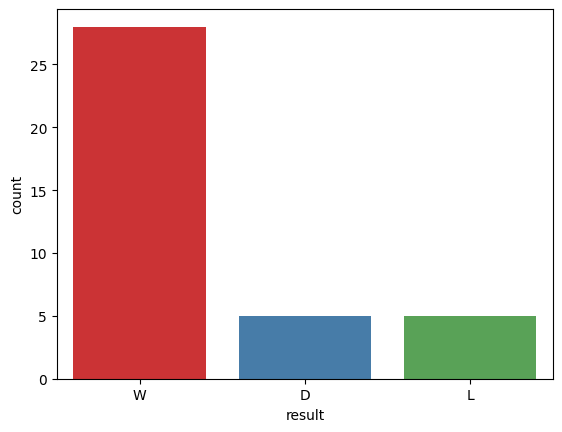

In [10]:
sns.countplot(x="result", data=test_df, palette="Set1");

In [11]:
test_df_with_opponent = test_df[
    [
        "opponent",
        "result",
        "venue",
        "season",
        "win_percent_before_team2",
        "win_percent_diff",
        "lose_percent_before_team2",
        "head2head_win_percent",
        "head2head_draw_percent",
        "head2head_lost_percent",
        "is_opponent_big6",
        "ELO_before_match_team2",
        "ELO_before_diff",
        "average_score_before_match_team2",
    ]
]

test_df = test_df[
    [
        "opponent",
        "result",
        "venue",
        "season",
        "win_percent_before_team2",
        "win_percent_diff",
        "lose_percent_before_team2",
        "head2head_win_percent",
        "head2head_draw_percent",
        "head2head_lost_percent",
        "is_opponent_big6",
        "ELO_before_match_team2",
        "ELO_before_diff",
        "average_score_before_match_team2",
    ]
]

In [12]:
test_df.head()

,opponent,result,venue,season,win_percent_before_team2,win_percent_diff,lose_percent_before_team2,head2head_win_percent,head2head_draw_percent,head2head_lost_percent,is_opponent_big6,ELO_before_match_team2,ELO_before_diff,average_score_before_match_team2
0,Nottingham Forest,W,Home,2023-2024,0.000000,0.00,0.000000,0.5,0.0,0.5,0,1500.000000,0.000000,0.00
1,Crystal Palace,W,Away,2023-2024,1.000000,0.00,0.000000,0.3,0.5,0.2,0,1531.250000,0.000000,3.00
2,Fulham,D,Home,2023-2024,0.500000,0.50,0.500000,0.8,0.2,0.0,0,1483.575496,78.924504,1.50
3,Manchester United,W,Home,2023-2024,0.666667,0.00,0.333333,0.5,0.3,0.2,1,1528.623448,28.293188,2.00
4,Everton,W,Away,2023-2024,0.000000,0.75,0.750000,0.4,0.1,0.5,0,1391.908650,199.460931,0.25


In [13]:
test_df.columns

Index(['opponent', 'result', 'venue', 'season', 'win_percent_before_team2',
       'win_percent_diff', 'lose_percent_before_team2',
       'head2head_win_percent', 'head2head_draw_percent',
       'head2head_lost_percent', 'is_opponent_big6', 'ELO_before_match_team2',
       'ELO_before_diff', 'average_score_before_match_team2'],
      dtype='object')

##### Phân chia dữ liệu thành X, y

In [14]:
X_test = test_df.drop(["result","opponent"], axis=1)
y_test = test_df["result"]

In [15]:
X_test.head()

,venue,season,win_percent_before_team2,win_percent_diff,lose_percent_before_team2,head2head_win_percent,head2head_draw_percent,head2head_lost_percent,is_opponent_big6,ELO_before_match_team2,ELO_before_diff,average_score_before_match_team2
0,Home,2023-2024,0.000000,0.00,0.000000,0.5,0.0,0.5,0,1500.000000,0.000000,0.00
1,Away,2023-2024,1.000000,0.00,0.000000,0.3,0.5,0.2,0,1531.250000,0.000000,3.00
2,Home,2023-2024,0.500000,0.50,0.500000,0.8,0.2,0.0,0,1483.575496,78.924504,1.50
3,Home,2023-2024,0.666667,0.00,0.333333,0.5,0.3,0.2,1,1528.623448,28.293188,2.00
4,Away,2023-2024,0.000000,0.75,0.750000,0.4,0.1,0.5,0,1391.908650,199.460931,0.25


#### 2. Chuẩn hoá, encoding dữ liệu

In [16]:
label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(test_df["result"])

In [17]:
# D: 0
# L: 1
# W: 2
y_test

array([2, 2, 0, 2, 2, 0, 2, 2, 0, 2, 1, 2, 2, 2, 2, 1, 2, 0, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2])

In [18]:
# Áp dụng preprocessor đã lưu
transformed_X = preprocessor.transform(X_test)

# Lấy tên các cột đã được chuyển đổi từ tất cả các thành phần của preprocessor
venue_features = list(preprocessor.named_transformers_["venue"].get_feature_names_out())
season_features = list(preprocessor.named_transformers_["season"].get_feature_names_out())

# Xác định các cột phân loại và cột số
categorical_cols = X_test.select_dtypes(include=['object', 'category']).columns
numerical_cols = X_test.select_dtypes(include=['int32', 'int64', 'float64']).columns

numerical_cols, categorical_cols

# Gộp tất cả các tên cột lại
columns = (
    venue_features +
    season_features +
    numerical_cols.tolist()
)

# In ra để kiểm tra số lượng cột từ mỗi transformer và tổng số
print(f"Number of 'venue' features: {len(venue_features)}")
print(f"Number of 'season' features: {len(season_features)}")
print(f"Number of numerical columns: {len(numerical_cols)}")
print(f"Total number of columns expected: {len(columns)}")
print(f"Actual number of features in transformed_X: {transformed_X.shape[1]}")

# Kiểm tra xem có khớp với số lượng cột trong transformed_X không
if len(columns) == transformed_X.shape[1]:
    transformed_X = pd.DataFrame(transformed_X, columns=columns)
    print(transformed_X.head())
else:
    print("Mismatch in the number of expected and actual features.")

Number of 'venue' features: 2
Number of 'season' features: 5
Number of numerical columns: 10
Total number of columns expected: 17
Actual number of features in transformed_X: 17
   venue_Away  venue_Home  season_0  season_1  season_2  season_3  season_4  \
0         0.0         1.0       0.0       0.0       0.0       0.0       0.0   
1         1.0         0.0       0.0       0.0       0.0       0.0       0.0   
2         0.0         1.0       0.0       0.0       0.0       0.0       0.0   
3         0.0         1.0       0.0       0.0       0.0       0.0       0.0   
4         1.0         0.0       0.0       0.0       0.0       0.0       0.0   

   win_percent_before_team2  win_percent_diff  lose_percent_before_team2  \
0                 -1.362390         -0.520879                  -1.435440   
1                  2.376723         -0.520879                  -1.435440   
2                  0.507166          0.902806                   0.540040   
3                  1.130352         -0.52087

In [19]:
X_test.head()

,venue,season,win_percent_before_team2,win_percent_diff,lose_percent_before_team2,head2head_win_percent,head2head_draw_percent,head2head_lost_percent,is_opponent_big6,ELO_before_match_team2,ELO_before_diff,average_score_before_match_team2
0,Home,2023-2024,0.000000,0.00,0.000000,0.5,0.0,0.5,0,1500.000000,0.000000,0.00
1,Away,2023-2024,1.000000,0.00,0.000000,0.3,0.5,0.2,0,1531.250000,0.000000,3.00
2,Home,2023-2024,0.500000,0.50,0.500000,0.8,0.2,0.0,0,1483.575496,78.924504,1.50
3,Home,2023-2024,0.666667,0.00,0.333333,0.5,0.3,0.2,1,1528.623448,28.293188,2.00
4,Away,2023-2024,0.000000,0.75,0.750000,0.4,0.1,0.5,0,1391.908650,199.460931,0.25


In [20]:
# Áp dụng mô hình phân cụm để dự đoán nhãn cụm cho dữ liệu kiểm thử
clusters = kmeans_model.predict(transformed_X)
X_test['Cluster'] = clusters
X_test['match_type'] = X_test['Cluster'].apply(assign_cluster_label)
X_test['win_rate_type'] = X_test['Cluster'].apply(assign_win_label)

In [21]:
transformed_X.head()

,venue_Away,venue_Home,season_0,season_1,season_2,season_3,season_4,win_percent_before_team2,win_percent_diff,lose_percent_before_team2,head2head_win_percent,head2head_draw_percent,head2head_lost_percent,is_opponent_big6,ELO_before_match_team2,ELO_before_diff,average_score_before_match_team2
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.362390,-0.520879,-1.435440,-0.109561,-1.169633,1.487517,-0.595390,0.026422,-0.826088,-1.794548
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.376723,-0.520879,-1.435440,-0.845269,1.463192,0.010802,-0.595390,0.155401,-0.826088,2.225725
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.507166,0.902806,0.540040,0.994002,-0.116503,-0.973674,-0.595390,-0.041368,-0.577540,0.215589
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.130352,-0.520879,-0.118454,-0.109561,0.410062,0.010802,1.679572,0.144560,-0.736988,0.885634
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.362390,1.614648,1.527780,-0.477415,-0.643068,1.487517,-0.595390,-0.419707,-0.197948,-1.459525


In [22]:
X_test.head()

,venue,season,win_percent_before_team2,win_percent_diff,lose_percent_before_team2,head2head_win_percent,head2head_draw_percent,head2head_lost_percent,is_opponent_big6,ELO_before_match_team2,ELO_before_diff,average_score_before_match_team2,Cluster,match_type,win_rate_type
0,Home,2023-2024,0.000000,0.00,0.000000,0.5,0.0,0.5,0,1500.000000,0.000000,0.00,2,Strong Opponent,High Win Rate
1,Away,2023-2024,1.000000,0.00,0.000000,0.3,0.5,0.2,0,1531.250000,0.000000,3.00,1,Weak Opponent,Diverse Win Rate
2,Home,2023-2024,0.500000,0.50,0.500000,0.8,0.2,0.0,0,1483.575496,78.924504,1.50,2,Strong Opponent,High Win Rate
3,Home,2023-2024,0.666667,0.00,0.333333,0.5,0.3,0.2,1,1528.623448,28.293188,2.00,1,Weak Opponent,Diverse Win Rate
4,Away,2023-2024,0.000000,0.75,0.750000,0.4,0.1,0.5,0,1391.908650,199.460931,0.25,0,Average Opponent,Low Win Rate


In [23]:
preprocessor_clustering.feature_names_in_

array(['Cluster', 'match_type', 'win_rate_type'], dtype=object)

In [24]:
# Áp dụng preprocessor đã lưu
transformed_X_clustering = preprocessor_clustering.transform(X_test)
columns_for_clustering = (
    ["Cluster"]
    + list(preprocessor_clustering.named_transformers_["match_type"].get_feature_names_out())
    + list(preprocessor_clustering.named_transformers_["win_rate_type"].get_feature_names_out())
)

In [25]:
X_test = pd.concat([transformed_X, pd.DataFrame(transformed_X_clustering, columns=columns_for_clustering)], axis=1)

In [26]:
X_test

,venue_Away,venue_Home,season_0,season_1,season_2,season_3,season_4,win_percent_before_team2,win_percent_diff,lose_percent_before_team2,...,head2head_lost_percent,is_opponent_big6,ELO_before_match_team2,ELO_before_diff,average_score_before_match_team2,Cluster,match_type_0,match_type_1,win_rate_type_0,win_rate_type_1
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.362390,-0.520879,-1.435440,...,1.487517,-0.595390,0.026422,-0.826088,-1.794548,1.485675,1.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.376723,-0.520879,-1.435440,...,0.010802,-0.595390,0.155401,-0.826088,2.225725,0.183104,0.0,1.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.507166,0.902806,0.540040,...,-0.973674,-0.595390,-0.041368,-0.577540,0.215589,1.485675,1.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.130352,-0.520879,-0.118454,...,0.010802,1.679572,0.144560,-0.736988,0.885634,0.183104,0.0,1.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.362390,1.614648,1.527780,...,1.487517,-0.595390,-0.419707,-0.197948,-1.459525,-1.119467,1.0,1.0,1.0,1.0
5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.628900,-0.520879,-1.435440,...,0.503041,1.679572,0.697166,-0.900707,1.689689,0.183104,0.0,1.0,0.0,1.0
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.362390,1.187543,0.935136,...,-0.481436,-0.595390,-0.501158,0.018987,-1.258511,-1.119467,1.0,1.0,1.0,1.0
7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.628900,-1.090353,-0.645248,...,3.948709,1.679572,0.838035,-0.759511,1.421670,0.183104,0.0,1.0,0.0,1.0
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.133255,0.618069,0.144944,...,0.503041,1.679572,0.228251,-0.201809,0.081580,1.485675,1.0,0.0,1.0,0.0
9,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.362390,1.187543,2.515520,...,0.667120,-0.595390,-1.182980,0.915581,-1.794548,-1.119467,1.0,1.0,1.0,1.0


##### Convert mùa giải mới (2023-2024) chưa có trong tập train thành binary

In [27]:
def int_to_binary_array(number, num_bits):
    binary_string = bin(number)[2:]  # Chuyển đổi thành chuỗi nhị phân, bỏ qua '0b' ở đầu
    binary_array = [int(bit) for bit in binary_string]  # Chuyển đổi mỗi ký tự của chuỗi thành một số nguyên
    
    # Điền vào các số 0 phía trước nếu cần thiết để đủ số lượng bit
    while len(binary_array) < num_bits:
        binary_array.insert(0, 0)
    return binary_array

In [28]:
X_test[["season_0", "season_1", "season_2", "season_3", "season_4"]] = int_to_binary_array(24, 5)
X_test.head()

,venue_Away,venue_Home,season_0,season_1,season_2,season_3,season_4,win_percent_before_team2,win_percent_diff,lose_percent_before_team2,...,head2head_lost_percent,is_opponent_big6,ELO_before_match_team2,ELO_before_diff,average_score_before_match_team2,Cluster,match_type_0,match_type_1,win_rate_type_0,win_rate_type_1
0,0.0,1.0,1,1,0,0,0,-1.362390,-0.520879,-1.435440,...,1.487517,-0.595390,0.026422,-0.826088,-1.794548,1.485675,1.0,0.0,1.0,0.0
1,1.0,0.0,1,1,0,0,0,2.376723,-0.520879,-1.435440,...,0.010802,-0.595390,0.155401,-0.826088,2.225725,0.183104,0.0,1.0,0.0,1.0
2,0.0,1.0,1,1,0,0,0,0.507166,0.902806,0.540040,...,-0.973674,-0.595390,-0.041368,-0.577540,0.215589,1.485675,1.0,0.0,1.0,0.0
3,0.0,1.0,1,1,0,0,0,1.130352,-0.520879,-0.118454,...,0.010802,1.679572,0.144560,-0.736988,0.885634,0.183104,0.0,1.0,0.0,1.0
4,1.0,0.0,1,1,0,0,0,-1.362390,1.614648,1.527780,...,1.487517,-0.595390,-0.419707,-0.197948,-1.459525,-1.119467,1.0,1.0,1.0,1.0


In [29]:
X_test.columns

Index(['venue_Away', 'venue_Home', 'season_0', 'season_1', 'season_2',
       'season_3', 'season_4', 'win_percent_before_team2', 'win_percent_diff',
       'lose_percent_before_team2', 'head2head_win_percent',
       'head2head_draw_percent', 'head2head_lost_percent', 'is_opponent_big6',
       'ELO_before_match_team2', 'ELO_before_diff',
       'average_score_before_match_team2', 'Cluster', 'match_type_0',
       'match_type_1', 'win_rate_type_0', 'win_rate_type_1'],
      dtype='object')

#### Testing

In [30]:
y_pred = RF_model.predict(X_test)
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

# Thêm cột kết quả dự đoán vào sau cột thứ 1 của dataframe
test_df.insert(1, "Predicted", label_encoder.inverse_transform(y_pred))
test_df_with_opponent.insert(2, "Predicted", label_encoder.inverse_transform(y_pred))

test_df_with_opponent.to_csv("test_results.csv", index=False)

### Confusion matrix

In [31]:
# Tính confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=RF_model.classes_)
cm

array([[ 1,  1,  3],
       [ 0,  0,  5],
       [ 2,  1, 25]], dtype=int64)

In [32]:
# Tính toán accuracy
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.6842105263157895

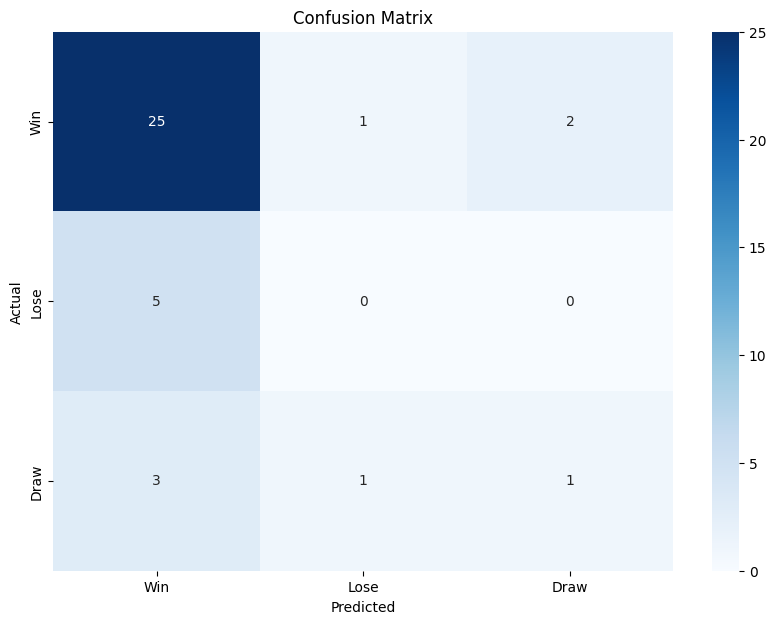

In [33]:
# Định nghĩa lại nhãn theo thứ tự mong muốn
original_labels = ['Draw', 'Lose', 'Win']
desired_labels = ['Win', 'Lose', 'Draw']
label_mapping = {label: i for i, label in enumerate(original_labels)}
desired_indices = [label_mapping[label] for label in desired_labels]
cm = cm[desired_indices][:, desired_indices]

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=desired_labels, yticklabels=desired_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [34]:
results_df = pd.DataFrame(test_df["Predicted"] == test_df["result"], columns=["Correct"])

In [35]:
df_results = pd.read_csv('test_results.csv')

mismatched_df = df_results[df_results['result'] != df_results['Predicted']]

display_df = mismatched_df[["opponent", "result", "Predicted"]]

display_df

,opponent,result,Predicted
2,Fulham,D,W
5,Tottenham Hotspur,D,W
6,Bournemouth,W,L
10,Newcastle United,L,W
12,Brentford,W,D
15,Aston Villa,L,W
17,Liverpool,D,L
18,West Ham United,L,W
19,Fulham,L,W
23,West Ham United,W,D
